In [3]:
d20_traces = ['web/web-vm.bin', 'homes/homes.bin', 'mail/mail.bin', 'online/online.bin', 'webmail/webmail.bin', 'webresearch/webresearch.bin', 'webusers/webusers.bin']
d6_traces = ['msr/MSR-Cambridge/hm.bin', 'msr/MSR-Cambridge/mds.bin', 'msr/MSR-Cambridge/prn.bin', 'msr/MSR-Cambridge/proj.bin', 'msr/MSR-Cambridge/prxy.bin', 'msr/MSR-Cambridge/rsrch.bin']

In [ ]:
import multiprocessing
import subprocess

traces = ['online/online.bin', 'webmail/webmail.bin', 'webresearch/webresearch.bin', 'webusers/webusers.bin']
versioning_factor = "0.1"

n_cores = 3

def run_analyze_disk_usage_parallel(trace_filenames):
    
    def run_analyze_disk_usage(trace_file):
        # Call the analyze_disk_usage script with the trace file
        subprocess.run(['python3', 'analyze_disk_usage.py', trace_file, versioning_factor])

    processes = []

    # Create a process for each trace file
    for trace_file in trace_filenames[:n_cores]:
        p = multiprocessing.Process(target=run_analyze_disk_usage, args=(trace_file,))
        processes.append(p)
        p.start()

    # Wait for all processes to complete
    for p in processes:
        p.join()
    
    

for i in range(0, len(traces), n_cores):
    run_analyze_disk_usage_parallel(trace_filenames = traces[i:i+n_cores])
    print("Finished analyzing traces {0}-{1}".format(i, i+n_cores-1))

versioning_overhead GB:  18.31378


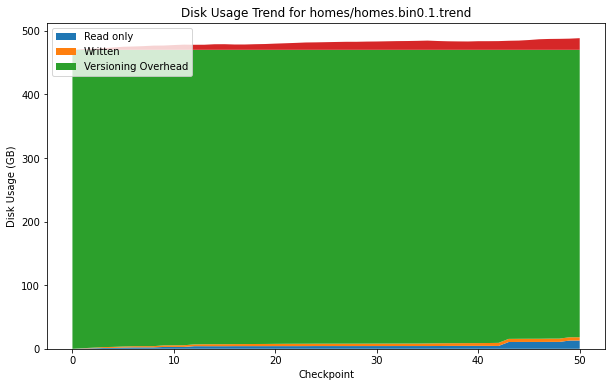

Finished plotting trend for homes/homes.bin


In [28]:
import matplotlib.pyplot as plt

trace_logic_disk_usage = {
    "web/web-vm.bin": 70,
    "homes/homes.bin": 470,
}

# traces = d20_traces
traces = ["homes/homes.bin"]
versioning_factor = "0.1"

def plot_trend(trend_filename, disk_max=100):
    # Read disk_usage_trend back from the file
    read_disk_usage_trend = []
    with open(trend_filename, 'r') as file:
        for line in file:
            read_disk_usage_trend.append(eval(line.strip()))
    # Extract data for plotting
    accessed_blocks = [entry[0] for entry in read_disk_usage_trend]
    written_blocks = [entry[1] for entry in read_disk_usage_trend]
    versioning_block_count = [entry[2] for entry in read_disk_usage_trend]
    
    # Calculate the stacked areas
    versioning_overhead = [v - w for v, w in zip(versioning_block_count, written_blocks)]
    read_blocks = [a - v for a, v in zip(accessed_blocks, written_blocks)]
    
    def block_number_to_GB(block_number):
        return [a * 4.0 / 1e6 for a in block_number]
    
    read_GB = block_number_to_GB(read_blocks)
    written_GB = block_number_to_GB(written_blocks)
    untouched_GB = [disk_max - (r + w) for r, w in zip(read_GB, written_GB)]
    versioning_overhead_GB = block_number_to_GB(versioning_overhead)
    
    print("versioning_overhead GB: ", versioning_overhead_GB[-1])

    # Plot the data
    plt.figure(figsize=(10, 6))
    plt.stackplot(range(len(accessed_blocks)), read_GB, written_GB, untouched_GB, versioning_overhead_GB, labels=['Read only', 'Written', 'Versioning Overhead'])
    plt.xlabel('Checkpoint')
    plt.ylabel('Disk Usage (GB)')
    plt.title(f'Disk Usage Trend for {trend_filename}')
    plt.legend(loc='upper left')
    plt.show()

for trace in traces:
    trend_filename = trace + versioning_factor + ".trend"
    plot_trend(trend_filename, trace_logic_disk_usage[trace])
    print("Finished plotting trend for {0}".format(trace))

In [43]:
import datetime
import pickle

def parse_trace(trace_filename, start_time, traces):
    last_checkpoint = start_time
    checkpoint_time = datetime.timedelta(hours=1) 
    with open(trace_filename, 'r') as file:
        for line in file:
            # Split the line into components
            parts = line.strip().split()
            if len(parts) != 9:
                print("Skipped"+line)
                continue  # Skip lines that don't have enough parts

            # Extract the fields
            time = datetime.timedelta(milliseconds=int(parts[0])//1e6) + start_time
            lba = int(parts[3])
            size_blocks = int(parts[4])
            operation = parts[5]
            
            traces.append((time, lba, size_blocks, operation))
            
            # Print Time
            if last_checkpoint + checkpoint_time <= time:
                print(time.strftime("%Y-%m-%d %H:%M:%S"))
                last_checkpoint = time



def parse_traces_to_bin(trace_filenames, bin_filename): 
    start_time = datetime.datetime(year=2000, month=1, day=1)
    traces = []
    for filename in trace_filenames:
        parse_trace(filename, start_time, traces)
        print("Finish filename " + filename)
    
    # Write the traces list to a binary file
    with open(bin_filename, 'wb') as bin_file:
        pickle.dump(traces, bin_file)
    print(f"Traces written to {bin_filename}")

In [44]:
import datetime

homes_traces = [f"homes/homes-110108-112108.{i}.blkparse" for i in range(1, 21)]
mails_traces = [f"mail/cheetah.cs.fiu.edu-110108-113008.{i}.blkparse" for i in range(1, 21)]



# parse_traces_to_bin(homes_traces, "homes/home.time.bin")
parse_traces_to_bin([f"mail/cheetah.cs.fiu.edu-110108-113008.{i}.blkparse" for i in range(1, 4)], "mail/mail0.time.bin")
parse_traces_to_bin([f"mail/cheetah.cs.fiu.edu-110108-113008.{i}.blkparse" for i in range(4, 7)], "mail/mail1.time.bin")
parse_traces_to_bin([f"mail/cheetah.cs.fiu.edu-110108-113008.{i}.blkparse" for i in range(7, 10)], "mail/mail2.time.bin")
parse_traces_to_bin([f"mail/cheetah.cs.fiu.edu-110108-113008.{i}.blkparse" for i in range(10, 13)], "mail/mail3.time.bin")
parse_traces_to_bin([f"mail/cheetah.cs.fiu.edu-110108-113008.{i}.blkparse" for i in range(13, 16)], "mail/mail4.time.bin")
parse_traces_to_bin([f"mail/cheetah.cs.fiu.edu-110108-113008.{i}.blkparse" for i in range(16, 19)], "mail/mail5.time.bin")
parse_traces_to_bin([f"mail/cheetah.cs.fiu.edu-110108-113008.{i}.blkparse" for i in range(19, 22)], "mail/mail6.time.bin")

Skipped./PaxHeaders.15436/cheetah.cs.fiu.edu-110108-113008.2.blkparse                                      0000644 0104650 0034636 00000000072 11475534322 021003  x                                                                                                    ustar 00                                                                0000000 0000000                                                                                                                                                                        30 atime=1410563628.272753818

Skipped28 ctime=1410563671.7201132

Skipped                                                                                                                                                                                                                                                                                                                                                                                                                       

In [1]:
import datetime
import pickle

def block_number_to_GB(block_number):
    return block_number * 4.0 / 1e6 # 4KB per block

def epoch(cached_blocks, versioning_blocks, expire_window, current_time):
    cached_count = len(cached_blocks)
    expired_count = 0
    for blockid, time in cached_blocks.items():
        if blockid not in versioning_blocks:
            versioning_blocks[blockid] = []
        versioning_blocks[blockid].append(time)
        expired_count += clear_expired_blocks(versioning_blocks, current_time - expire_window, blockid)
    cached_blocks.clear()
    return cached_count - expired_count


def clear_expired_blocks(versioning_blocks, expired_time, block_id):
    expired_count = 0
    if block_id in versioning_blocks:
        old_copy_count = len(versioning_blocks[block_id])
        versioning_blocks[block_id] = [t for t in versioning_blocks[block_id] if t >= expired_time]
        expired_count = old_copy_count - len(versioning_blocks[block_id])
    return expired_count

def execute_trace(trace, lock_win, expire_win, accessed_blocks, written_blocks, cached_blocks, versioning_blocks, last_epoch_time, versioning_block_count, f_disk_usage_trend):
    trend_checkpoint_time = datetime.timedelta(minutes=30)
    last_checkpoint = datetime.datetime.min
    
    
    for s in trace: 
        time, lba, size, command = s
        num_blocks = size // 8
        block_id = lba // 8
        for id in range(block_id, block_id + num_blocks):
            if command == "R":
                accessed_blocks.add(id)
            elif command == "W":
                written_blocks.add(id)
            else:
                print("Invalid command")
            
            if command == "W":
                cached_blocks[id] = time
        
        if time - last_epoch_time > lock_win:
            new_versioning_count = epoch(cached_blocks, versioning_blocks, expire_win, time)
            versioning_block_count += new_versioning_count
            last_epoch_time = time
            
        if time >= last_checkpoint + trend_checkpoint_time:
            print(time.strftime("%Y-%m-%d %H:%M:%S") + "... ",
                f"Accessed: {block_number_to_GB(len(accessed_blocks)):.2f} GB ",
                f"Written {block_number_to_GB(len(written_blocks)):.2f} GB ",
                f"vs Versioning {block_number_to_GB(versioning_block_count):.2f} GB ",
                f"+ {block_number_to_GB(len(cached_blocks)):.2f} GB "
            )
            f_disk_usage_trend.write(str((time.strftime("%Y-%m-%d %H:%M:%S"), len(accessed_blocks), len(written_blocks), versioning_block_count+len(cached_blocks))) + "\n")
            last_checkpoint = time



def analyze_disk_usage(traces_filesname, lock_window, expire_window):
    start_time = datetime.datetime(year=2000, month=1, day=1)
    accessed_blocks = set()
    written_blocks = set()
    versioning_blocks = {}
    cached_blocks = {}
    
    
    last_epoch_time = start_time
    versioning_block_count = 0
    
    import re
    trend_filename = re.sub('\.time.bin$', '', traces_filesname[0])
    trend_filename = trend_filename + "-" + str(int(lock_window.total_seconds()) // (60 * 60)) + "H-" + str(int(expire_window.total_seconds()) // (60 * 60)) + "H.trend"
    
    with open(trend_filename, 'w') as f_disk_usage_trend:
        for filename in traces_filesname:
            with open(filename, 'rb') as file:
                traces = pickle.load(file)
                execute_trace(traces, lock_window, expire_window, accessed_blocks, written_blocks, cached_blocks, versioning_blocks, last_epoch_time, versioning_block_count, f_disk_usage_trend)
    print("Written to " + trend_filename)


In [45]:
# analyze_disk_usage(["homes/homes.time.bin"], datetime.timedelta(hours=1), datetime.timedelta(days=2))
# analyze_disk_usage(["homes/homes.time.bin"], datetime.timedelta(hours=0), datetime.timedelta(days=2))
# analyze_disk_usage(["homes/homes.time.bin"], datetime.timedelta(hours=1), datetime.timedelta(days=10))

mail_bins = ["mail/mail0.time.bin", "mail/mail1.time.bin", "mail/mail2.time.bin", "mail/mail3.time.bin", "mail/mail4.time.bin", "mail/mail5.time.bin", "mail/mail6.time.bin"]
analyze_disk_usage(mail_bins, datetime.timedelta(hours=1), datetime.timedelta(days=2))

2000-01-02 00:59:26...  Accessed: 0.00 GB  Written 0.00 GB  vs Versioning 0.00 GB  + 0.00 GB 
2000-01-02 02:00:07...  Accessed: 0.19 GB  Written 0.27 GB  vs Versioning 0.27 GB  + 0.00 GB 
2000-01-02 02:30:07...  Accessed: 0.98 GB  Written 0.69 GB  vs Versioning 0.27 GB  + 0.54 GB 
2000-01-02 03:00:08...  Accessed: 1.49 GB  Written 0.89 GB  vs Versioning 1.13 GB  + 0.00 GB 
2000-01-02 03:30:09...  Accessed: 2.17 GB  Written 1.11 GB  vs Versioning 1.13 GB  + 0.69 GB 
2000-01-02 04:00:09...  Accessed: 2.74 GB  Written 1.23 GB  vs Versioning 2.18 GB  + 0.00 GB 
2000-01-02 04:30:09...  Accessed: 3.59 GB  Written 1.31 GB  vs Versioning 2.18 GB  + 0.66 GB 
2000-01-02 05:00:10...  Accessed: 3.72 GB  Written 1.39 GB  vs Versioning 3.18 GB  + 0.00 GB 
2000-01-02 05:30:10...  Accessed: 3.79 GB  Written 1.43 GB  vs Versioning 3.18 GB  + 0.77 GB 
2000-01-02 06:00:10...  Accessed: 3.84 GB  Written 1.46 GB  vs Versioning 4.06 GB  + 0.00 GB 
2000-01-02 06:30:11...  Accessed: 3.84 GB  Written 1.48 GB  

In [40]:
import pandas as pd
import matplotlib.pyplot as plt

def parse_line(line):
    start_time = datetime.datetime(year=2000, month=1, day=1)
    # Remove parentheses and split by comma
    line = line.strip().strip('()')
    parts = line.split(', ')
    # Convert parts to appropriate types
    time = datetime.datetime.strptime(parts[0].strip("'"), '%Y-%m-%d %H:%M:%S')
    read_only_blocks = int(parts[1])
    written_blocks = int(parts[2])
    versioning_blocks = int(parts[3])
    
    versioning_overhead = versioning_blocks - written_blocks
    return time, read_only_blocks, written_blocks, versioning_overhead

def plot_blocks_over_time(filename, logic_disk_usage_GB):
    # Step 1: Read and parse the data from the file
    with open(filename, 'r') as file:
        lines = file.readlines()
    
    data = [parse_line(line) for line in lines]
    
    # Step 2: Convert the data into a pandas DataFrame
    df = pd.DataFrame(data, columns=['time', 'read_only_blocks', 'written_blocks', 'versioning_overhead'])
    
    # Step 3: Convert the data to GB if necessary
    # Assuming the data is in bytes, convert to GB
    df['readonly_GB'] = block_number_to_GB(df['read_only_blocks'])
    df['written_GB'] = block_number_to_GB(df['written_blocks'])
    df['not_touched_GB'] = [logic_disk_usage_GB - block_number_to_GB(r + w) for r, w in zip(df['read_only_blocks'], df['written_blocks'])]
    df['versioning_GB'] = block_number_to_GB(df['versioning_overhead'])
    
    
    print("written GB: ", df['written_GB'].iloc[-1])
    print("read GB: ", df['readonly_GB'].iloc[-1])
    print("versioning_overhead GB: ", df['versioning_GB'].iloc[-1])
    print("Logic Space GB: ", logic_disk_usage_GB)
    
    # Step 4: Plot the data using a stacked area plot
    plt.figure(figsize=(10, 6))
    plt.stackplot(df['time'], 
                  df['readonly_GB'], 
                  df['written_GB'], 
                  df['not_touched_GB'],
                  df['versioning_GB'], 
                  labels=['Read', 'Write', 'Logic Space', 'Versioning Overhead'])
    
    # Step 5: Add labels and legend
    plt.xlabel('Time')
    plt.ylabel('Blocks in GB')
    plt.title('Readonly, Written, and Versioning Disk Usage Over Time: ' + filename)
    plt.legend(loc='upper left')
    
    # Step 6: Show the plot
    plt.show()

# Example usage

written GB:  5.1937
read GB:  13.939568
versioning_overhead GB:  4.14514
Logic Space GB:  470


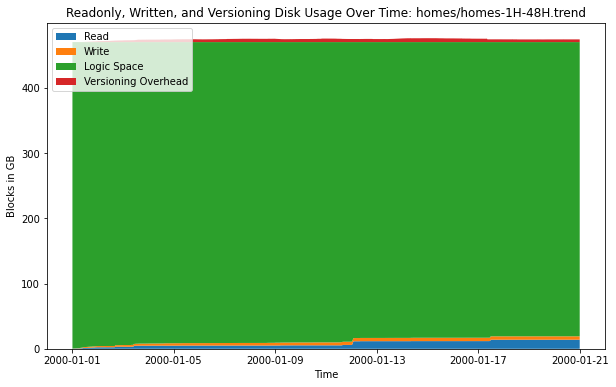

written GB:  5.1937
read GB:  13.939568
versioning_overhead GB:  16.918876
Logic Space GB:  470


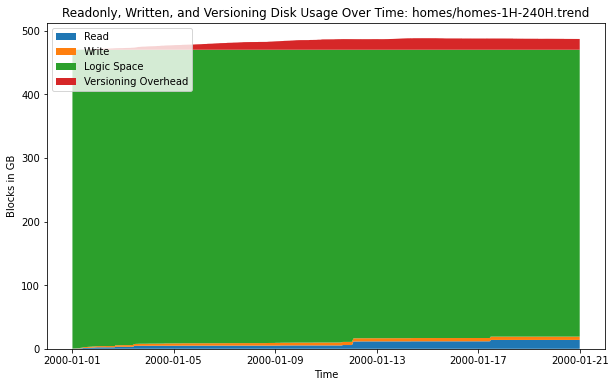

In [41]:

plot_blocks_over_time('homes/homes-1H-48H.trend', 470)
# plot_blocks_over_time('homes/homes-0H-48H.trend')
plot_blocks_over_time('homes/homes-1H-240H.trend', 470)